In [1]:
%reload_ext autoreload
%autoreload 2

from ripple_heterogeneity.utils import (
    functions,
    loading,
    batch_analysis,
    add_new_deep_sup,
    custom_plots,
    compress_repeated_epochs
)
from ripple_heterogeneity.readout import assembly_multi_region, assembly_multi_region_pos_maps_tmaze,assembly_multi_region_pos_maps_tmaze_ind_detect
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import AutoMinorLocator
import os
import nelpy as nel
from statannot import add_stat_annotation
from statannotations.Annotator import Annotator
import glob
import pickle
import itertools
from ripple_heterogeneity.place_cells import maps
from scipy import stats
from scipy.stats import zscore
from statsmodels.stats.proportion import proportions_ztest
from sklearn.linear_model import LinearRegression
import random

functions.set_plotting_defaults()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## locate sessions

In [2]:
df = pd.read_csv(r"Z:\home\ryanh\projects\ripple_heterogeneity\sessions.csv")

epoch_df = pd.DataFrame()
for basepath in df.basepath.unique():

    epoch_df_ = loading.load_epoch(basepath)
    df_temp_regions = pd.DataFrame()
    df_temp_regions["regions"] = loading.load_brain_regions(basepath).keys()
    epoch_df_["mec"] = df_temp_regions.regions.str.contains("EC1|EC2|EC3|EC4|EC5|MEC").any()
    epoch_df_["pfc"] = df_temp_regions.regions.str.contains("PFC").any()

    epoch_df_["basepath"] = basepath

    epoch_df = pd.concat([epoch_df,epoch_df_],ignore_index=True)

In [3]:
session_df = pd.DataFrame()
session_df["basepath"] = epoch_df.query("environment.str.contains('Mwheel|Tmaze|tmaze') & (mec|pfc)").basepath.unique()
# session_df.to_csv(r"Z:\home\ryanh\projects\ripple_heterogeneity\tmaze_sessions.csv",index=False)

## main analysis

In [50]:
# basepath = r"Z:\Data\AYAold\AYA10\day12"
# results = assembly_multi_region_pos_maps_tmaze_ind_detect.run(basepath)

# cross_regions = (("CA1","PFC"),("CA1","EC1|EC2|EC3|EC4|EC5|MEC"))
# cross_regions

In [242]:
# save_path = (r"Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_pos_maps_tmaze_ind_detect_v2")
# save_path = (r"Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_pos_maps_tmaze_ind_detect_v3")
save_path = (r"Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_pos_maps_tmaze_ind_detect_v4")

batch_analysis.run(
    session_df,
    save_path,
    assembly_multi_region_pos_maps_tmaze_ind_detect.run,
    parallel=True,
    overwrite=False,
    verbose=False,
    skip_if_error=False,
)
# load results
tc, label_df = assembly_multi_region_pos_maps_tmaze_ind_detect.load_results(save_path)

100%|██████████| 53/53 [00:13<00:00,  3.83it/s] 


Loading results...


## simplify labels

In [243]:
label_df.loc[label_df.cross_region_label=="Deep_EC1|EC2|EC3|EC4|EC5|MEC","cross_region_label"] = "deep_mec"
label_df.loc[label_df.cross_region_label=="Superficial_EC1|EC2|EC3|EC4|EC5|MEC","cross_region_label"] = "sup_mec"
label_df.loc[label_df.cross_region_label=="Deep_PFC","cross_region_label"] = "deep_pfc"
label_df.loc[label_df.cross_region_label=="Superficial_PFC","cross_region_label"] = "sup_pfc"
label_df

,assembly_n,direction_label,cross_region_label,x_start,x_decision,x_reward_left,x_reward_right,basepath
0,0,right_epochs,deep_mec,0.0,141.857161,342.426620,320.742053,Z:\Data\AYAold\AYA10\day12
1,1,right_epochs,deep_mec,0.0,141.857161,342.426620,320.742053,Z:\Data\AYAold\AYA10\day12
2,2,right_epochs,deep_mec,0.0,141.857161,342.426620,320.742053,Z:\Data\AYAold\AYA10\day12
3,3,right_epochs,deep_mec,0.0,141.857161,342.426620,320.742053,Z:\Data\AYAold\AYA10\day12
4,4,right_epochs,deep_mec,0.0,141.857161,342.426620,320.742053,Z:\Data\AYAold\AYA10\day12
...,...,...,...,...,...,...,...,...
439,0,left_epochs,deep_mec,0.0,87.984048,257.212112,257.810041,Z:\Data\Kenji\ec014.427_456
440,0,right_epochs,deep_mec,0.0,95.295897,263.816426,252.098965,Z:\Data\Kenji\ec016.479_487
441,1,right_epochs,sup_mec,0.0,95.295897,263.816426,252.098965,Z:\Data\Kenji\ec016.479_487
442,0,left_epochs,deep_mec,0.0,95.295897,263.816426,252.098965,Z:\Data\Kenji\ec016.479_487


In [244]:
label_df.cross_region_label.unique()

array(['deep_mec', 'sup_mec', 'deep_pfc', 'sup_pfc'], dtype=object)

In [245]:
ratemaps = []
for tc_ in tc:
    for ratemap in tc_.values.T:
        ratemaps.append(np.interp(np.linspace(0,len(ratemap),100),np.arange(len(ratemap)),ratemap))
ratemaps = np.vstack(ratemaps)
ratemaps[np.isnan(ratemaps)] = 0
ratemaps = zscore(ratemaps,axis=1)

## get ratemaps beyond the decision point

In [246]:
ratemaps = []
for basepath_i, basepath in enumerate(label_df.basepath.unique()):

    label_df_current = label_df.query("basepath==@basepath")
    right_epochs_maps = tc[basepath_i].iloc[tc[basepath_i].index > label_df.x_decision[basepath_i]+6,(label_df_current.direction_label=="right_epochs").values]
    left_epochs_maps = tc[basepath_i].iloc[tc[basepath_i].index > label_df.x_decision[basepath_i]+6,(label_df_current.direction_label=="left_epochs").values]


    for i in range(tc[basepath_i].shape[1]):
        ratemap = tc[basepath_i].iloc[tc[basepath_i].index > label_df.x_decision[basepath_i],i]
        ratemaps.append(np.interp(np.linspace(0,len(ratemap),100),np.arange(len(ratemap)),ratemap))

ratemaps = np.vstack(ratemaps)
ratemaps[np.isnan(ratemaps)] = 0
ratemaps = zscore(ratemaps,axis=1)

In [252]:
# corrs = []
# for basepath_i, basepath in enumerate(label_df.basepath.unique()):

#     label_df_current = label_df.query("basepath==@basepath")
#     right_epochs_maps = tc[basepath_i].iloc[tc[basepath_i].index > label_df.x_decision[basepath_i],(label_df_current.direction_label=="right_epochs").values]
#     left_epochs_maps = tc[basepath_i].iloc[tc[basepath_i].index > label_df.x_decision[basepath_i],(label_df_current.direction_label=="left_epochs").values]

#     for i in range(right_epochs_maps.shape[1]):
#         corrs.append(np.corrcoef(right_epochs_maps.iloc[:,i].values,left_epochs_maps.iloc[:,i].values)[0,1])

# df_corrs = label_df.query("direction_label == 'right_epochs'").copy()
# df_corrs["corrs"] = corrs
# df_corrs["constant"] = 1

In [261]:
# df_corrs_expanded = pd.DataFrame()
# for temp_df in df_corrs.itertuples():
#     if (temp_df.n_deep > 0) & (temp_df.n_mec > 0):
#         # temp_df["labels"] = "deep_mec"
#         df_corrs_expanded = pd.concat([df_corrs_expanded,temp_df],ignore_index=True)
#         df_corrs_expanded.loc[-1,"labels"] = "deep_mec"

#     if (temp_df.n_sup > 0) & (temp_df.n_mec > 0):
#         temp_df["labels"] = "sup_mec"
#         df_corrs_expanded = pd.concat([df_corrs_expanded,temp_df],ignore_index=True)

In [262]:
# df_corrs["labels"] = "unknown"
# df_corrs.loc[(df_corrs.n_deep > 0) & (df_corrs.n_mec > 0),"labels"] = "deep_mec"
# df_corrs.loc[(df_corrs.n_sup > 0) & (df_corrs.n_mec > 0),"labels"] = "sup_mec"
# df_corrs.loc[(df_corrs.n_deep > 0) & (df_corrs.n_pfc > 0),"labels"] = "deep_pfc"
# df_corrs.loc[(df_corrs.n_sup > 0) & (df_corrs.n_pfc > 0),"labels"] = "sup_pfc"
# df_corrs


In [237]:
label_df

,assembly_n,direction_label,cross_region_label,x_start,x_decision,x_reward_left,x_reward_right,basepath
0,0,right_epochs,deep_mec,0.0,141.857161,342.426620,320.742053,Z:\Data\AYAold\AYA10\day12
1,1,right_epochs,deep_mec,0.0,141.857161,342.426620,320.742053,Z:\Data\AYAold\AYA10\day12
2,2,right_epochs,deep_mec,0.0,141.857161,342.426620,320.742053,Z:\Data\AYAold\AYA10\day12
3,3,right_epochs,deep_mec,0.0,141.857161,342.426620,320.742053,Z:\Data\AYAold\AYA10\day12
4,4,right_epochs,deep_mec,0.0,141.857161,342.426620,320.742053,Z:\Data\AYAold\AYA10\day12
...,...,...,...,...,...,...,...,...
837,2,left_epochs,sup_mec,0.0,95.295897,263.816426,252.098965,Z:\Data\Kenji\ec016.479_487
838,3,left_epochs,sup_mec,0.0,95.295897,263.816426,252.098965,Z:\Data\Kenji\ec016.479_487
839,4,left_epochs,sup_mec,0.0,95.295897,263.816426,252.098965,Z:\Data\Kenji\ec016.479_487
840,5,left_epochs,sup_mec,0.0,95.295897,263.816426,252.098965,Z:\Data\Kenji\ec016.479_487


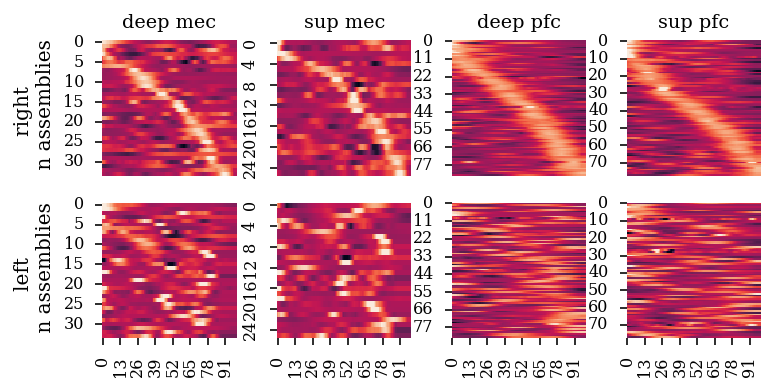

In [247]:
def make_snake(X):
    return np.argsort(np.argmax(X,axis=1))
fig, ax = plt.subplots(2,4, figsize=functions.set_size('thesis', fraction=1, subplots=(3, 4)), edgecolor=None)
fig.subplots_adjust(hspace = 0.2, wspace=.3)
ax = ax.ravel()

curr_maps = ratemaps[(label_df.cross_region_label == "deep_mec") & (label_df.direction_label == "right_epochs"),:]
idx = make_snake(curr_maps)
sns.heatmap(curr_maps[idx],vmin=-3,vmax=3,ax=ax[0],cbar=False,rasterized=True)
curr_maps = ratemaps[(label_df.cross_region_label == "deep_mec") & (label_df.direction_label == "left_epochs"),:]
sns.heatmap(curr_maps[idx],vmin=-3,vmax=3,ax=ax[4],cbar=False,rasterized=True)

curr_maps = ratemaps[(label_df.cross_region_label == "sup_mec") & (label_df.direction_label == "right_epochs"),:]
idx = make_snake(curr_maps)
sns.heatmap(curr_maps[idx],vmin=-3,vmax=3,ax=ax[1],cbar=False,rasterized=True)
curr_maps = ratemaps[(label_df.cross_region_label == "sup_mec") & (label_df.direction_label == "left_epochs"),:]
sns.heatmap(curr_maps[idx],vmin=-3,vmax=3,ax=ax[5],cbar=False,rasterized=True)

curr_maps = ratemaps[(label_df.cross_region_label == "deep_pfc") & (label_df.direction_label == "right_epochs"),:]
idx = make_snake(curr_maps)
sns.heatmap(curr_maps[idx],vmin=-3,vmax=3,ax=ax[2],cbar=False,rasterized=True)
curr_maps = ratemaps[(label_df.cross_region_label == "deep_pfc") & (label_df.direction_label == "left_epochs"),:]
sns.heatmap(curr_maps[idx],vmin=-3,vmax=3,ax=ax[6],cbar=False,rasterized=True)

curr_maps = ratemaps[(label_df.cross_region_label == "sup_pfc") & (label_df.direction_label == "right_epochs"),:]
idx = make_snake(curr_maps)
sns.heatmap(curr_maps[idx],vmin=-3,vmax=3,ax=ax[3],cbar=False,rasterized=True)
curr_maps = ratemaps[(label_df.cross_region_label == "sup_pfc") & (label_df.direction_label == "left_epochs"),:]
sns.heatmap(curr_maps[idx],vmin=-3,vmax=3,ax=ax[7],cbar=False,rasterized=True)

ax[0].set_title("deep mec")
ax[1].set_title("sup mec")
ax[2].set_title("deep pfc")
ax[3].set_title("sup pfc")

ax[0].set_ylabel("right \n n assemblies")
ax[4].set_ylabel("left \n n assemblies")

for i in [0,1,2,3]:
    ax[i].set_xticklabels([])
    ax[i].set_xticks([])
    ax[i].set_xlabel("")

## analyses

* direction correlation 
* reward encoding (%20 around loc)
* assembly rate map examples
* decision point encoding (%20 around loc)

## spatial correlations across right and left directions

In [248]:
corrs = []
labels = []

outbound_deep_mec = ratemaps[(label_df.cross_region_label == "deep_mec") & (label_df.direction_label == "right_epochs"),:]
inbound_deep_mec = ratemaps[(label_df.cross_region_label == "deep_mec") & (label_df.direction_label == "left_epochs"),:]

for i in range(outbound_deep_mec.shape[0]):
    corrs.append(np.corrcoef(outbound_deep_mec[i],inbound_deep_mec[i])[0,1])
    labels.append("deep_mec")

outbound = ratemaps[(label_df.cross_region_label == "sup_mec") & (label_df.direction_label == "right_epochs"),:]
inbound = ratemaps[(label_df.cross_region_label == "sup_mec") & (label_df.direction_label == "left_epochs"),:]
for i in range(outbound.shape[0]):
    corrs.append(np.corrcoef(outbound[i],inbound[i])[0,1])
    labels.append("sup_mec")
    
outbound = ratemaps[(label_df.cross_region_label == "deep_pfc") & (label_df.direction_label == "right_epochs"),:]
inbound = ratemaps[(label_df.cross_region_label == "deep_pfc")  & (label_df.direction_label == "left_epochs"),:]
for i in range(outbound.shape[0]):
    corrs.append(np.corrcoef(outbound[i],inbound[i])[0,1])
    labels.append("deep_pfc")

outbound = ratemaps[(label_df.cross_region_label == "sup_pfc") & (label_df.direction_label == "right_epochs"),:]
inbound = ratemaps[(label_df.cross_region_label == "sup_pfc") & (label_df.direction_label == "left_epochs"),:]
for i in range(outbound.shape[0]):
    corrs.append(np.corrcoef(outbound[i],inbound[i])[0,1])
    labels.append("sup_pfc")

df_corrs = pd.DataFrame()
df_corrs["corrs"] = corrs
df_corrs["labels"] = labels
df_corrs["constant"] = 1

c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:k'` for same effect.


Text(0.5, 0, '')

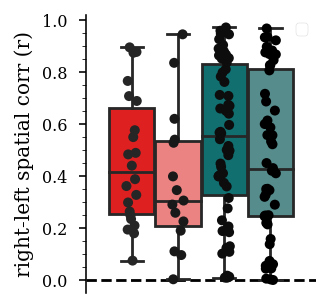

In [249]:
group_colors = {
    "deep_mec": "#de2020",
    "sup_mec": "#eb8383",
    "deep_pfc": "#116f70",
    "sup_pfc": "#568c8c",
}
sns.set_palette(sns.color_palette(group_colors.values()))

fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=0.35, subplots=(2, 1)), edgecolor=None
)
sns.boxplot(data=df_corrs.query("corrs>0"),x="constant",y="corrs",hue="labels",hue_order=group_colors.keys(),showfliers=False,saturation=1)
sns.stripplot(data=df_corrs.query("corrs>0"),x="constant",y="corrs",hue="labels",hue_order=group_colors.keys(),dodge=True,color="k")

sns.despine(bottom=True)
plt.legend("")
plt.ylabel("right-left spatial corr (r)")
plt.axhline(0,color="k",linestyle="--",zorder=-1000)
plt.gca().yaxis.set_minor_locator(AutoMinorLocator())
plt.gca().set_xticklabels([])
plt.gca().set_xticks([])
plt.gca().set_xlabel("")

In [347]:
df_corrs.to_csv(r"Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_pos_maps_tmaze_df_corrs.csv")

## reward representation

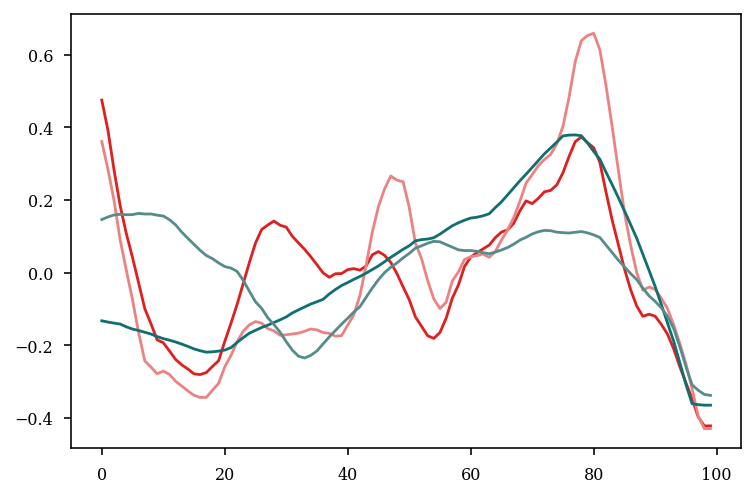

In [250]:
group_colors = {
    "deep_mec": "#de2020",
    "sup_mec": "#eb8383",
    "deep_pfc": "#116f70",
    "sup_pfc": "#568c8c",
}
sns.set_palette(sns.color_palette(group_colors.values()))

curr_maps = ratemaps[(label_df.cross_region_label == "deep_mec"),:]
plt.plot(curr_maps.mean(axis=0),label="deep_mec",color=group_colors["deep_mec"])

curr_maps = ratemaps[(label_df.cross_region_label == "sup_mec"),:]
plt.plot(curr_maps.mean(axis=0),label="sup_mec",color=group_colors["sup_mec"])

curr_maps = ratemaps[(label_df.cross_region_label == "deep_pfc"),:]
plt.plot(curr_maps.mean(axis=0),label="deep_pfc",color=group_colors["deep_pfc"])

curr_maps = ratemaps[(label_df.cross_region_label == "sup_pfc"),:]
plt.plot(curr_maps.mean(axis=0),label="sup_pfc",color=group_colors["sup_pfc"])
plt.show()

In [251]:
label_df = functions.add_animal_id(label_df)
len(tc),label_df.basepath.nunique(),label_df.animal_id.nunique()

(23, 23, 8)

## run regression between distance to reward and assembly strength

takes around 5-6 minutes to run

In [252]:
def score_xy(x, y, n_shuffles=400):
    reg = LinearRegression().fit(x, y)
    r2_obs = reg.score(x, y)
    slope = reg.coef_
    # shuffle x and fit
    r2_shuff = []
    for _ in range(n_shuffles):
        x_new = np.array(
            random.sample(list(x.flatten()), k=int(len(x.flatten())))
        ).reshape((-1, 1))
        reg = LinearRegression().fit(x_new, y)
        r2_shuff.append(reg.score(x_new, y))

    # significance test
    _, pval, std = functions.get_significant_events(r2_obs, np.array(r2_shuff))

    return r2_obs, r2_shuff, pval, std, slope


r2_obs = np.zeros_like(label_df.basepath.values) * np.nan
pval = np.zeros_like(r2_obs) * np.nan
std = np.zeros_like(r2_obs) * np.nan
slope = np.zeros_like(r2_obs) * np.nan
i = 0
for basepath_i, basepath in enumerate(label_df.basepath.unique()):

    label_df_current = label_df.query("basepath==@basepath")
    current_tc = tc[basepath_i]

    for col_i in current_tc.columns:

        if label_df_current.iloc[col_i].direction_label == "right_epochs":
            reward_x = label_df_current.iloc[col_i].x_reward_right

        elif label_df_current.iloc[col_i].direction_label == "left_epochs":
            reward_x = label_df_current.iloc[col_i].x_reward_left

        # do regression between distance to reward and assembly strength
        x = np.array(np.abs(current_tc.index - reward_x)).reshape((-1, 1))
        y = current_tc[col_i].values

        r2_obs[i], _, pval[i], std[i], slope[i] = score_xy(x, y)

        i += 1

In [255]:
label_df["reward_r2"] = np.hstack(r2_obs)
label_df["reward_pval"] = np.hstack(pval)
label_df["reward_shuffle_std"] = np.hstack(std)
label_df["reward_relation_slope"] = np.hstack(slope)
label_df["reward_encode"] = (label_df.reward_pval<0.05) & (label_df.reward_relation_slope < 0)

label_df

,assembly_n,direction_label,cross_region_label,x_start,x_decision,x_reward_left,x_reward_right,basepath,animal_id,reward_r2,reward_pval,reward_shuffle_std,reward_relation_slope,reward_encode
0,0,right_epochs,deep_mec,0.0,141.857161,342.426620,320.742053,Z:\Data\AYAold\AYA10\day12,AYA10,0.137863,0.002494,12.970596,0.000605,False
1,1,right_epochs,deep_mec,0.0,141.857161,342.426620,320.742053,Z:\Data\AYAold\AYA10\day12,AYA10,0.069197,0.004988,5.802285,0.000215,False
2,2,right_epochs,deep_mec,0.0,141.857161,342.426620,320.742053,Z:\Data\AYAold\AYA10\day12,AYA10,0.100909,0.002494,8.346535,-0.001944,True
3,3,right_epochs,deep_mec,0.0,141.857161,342.426620,320.742053,Z:\Data\AYAold\AYA10\day12,AYA10,0.034396,0.032419,2.522057,-0.000104,True
4,4,right_epochs,deep_mec,0.0,141.857161,342.426620,320.742053,Z:\Data\AYAold\AYA10\day12,AYA10,0.106944,0.002494,11.028362,-0.003654,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
439,0,left_epochs,deep_mec,0.0,87.984048,257.212112,257.810041,Z:\Data\Kenji\ec014.427_456,ec014,0.017600,0.211970,0.438577,0.000145,False
440,0,right_epochs,deep_mec,0.0,95.295897,263.816426,252.098965,Z:\Data\Kenji\ec016.479_487,ec016,0.004492,0.518703,-0.411634,0.000024,False
441,1,right_epochs,sup_mec,0.0,95.295897,263.816426,252.098965,Z:\Data\Kenji\ec016.479_487,ec016,0.005679,0.446384,-0.339853,0.000180,False
442,0,left_epochs,deep_mec,0.0,95.295897,263.816426,252.098965,Z:\Data\Kenji\ec016.479_487,ec016,0.037176,0.062344,1.985773,0.000088,False


<AxesSubplot:xlabel='reward_relation_slope', ylabel='reward_r2'>

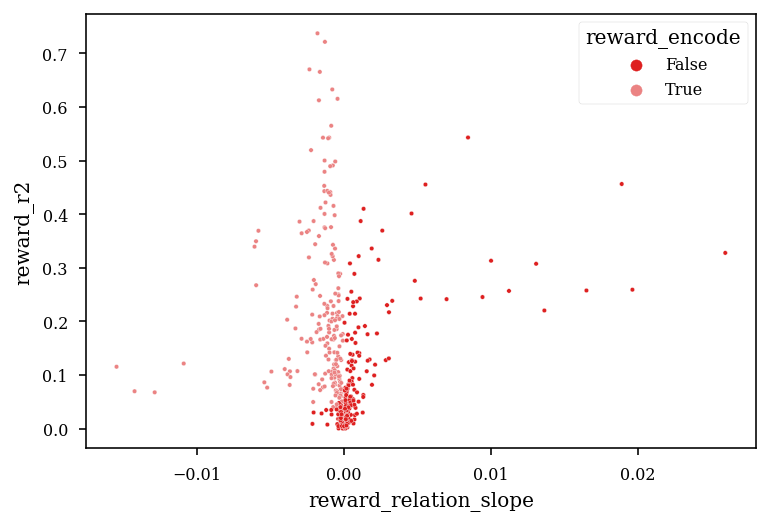

In [256]:
sns.scatterplot(data=label_df,x="reward_relation_slope",y="reward_r2",hue="reward_encode",s=5)

In [257]:
reward_assembly = []
for basepath_i, basepath in enumerate(label_df.basepath.unique()):

    label_df_current = label_df.query("basepath==@basepath")

    peak_locs = tc[basepath_i].index[np.argmax(tc[basepath_i].values, axis=0)]

    right_peaks = peak_locs[(label_df_current.direction_label == "right_epochs").values]
    left_peaks = peak_locs[(label_df_current.direction_label == "left_epochs").values]

    label_df.loc[(label_df.basepath == basepath) & (label_df.direction_label == "right_epochs"),"peak_loc"] = right_peaks
    label_df.loc[(label_df.basepath == basepath) & (label_df.direction_label == "left_epochs"),"peak_loc"] = left_peaks

    x_reward_right = label_df_current.x_reward_right.iloc[0]
    reward_assembly = (right_peaks > x_reward_right - 25) & (right_peaks < x_reward_right + 50)
    label_df.loc[(label_df.basepath == basepath) & (label_df.direction_label == "right_epochs"),"reward_assembly"] = reward_assembly
    
    x_reward_left = label_df_current.x_reward_left.iloc[0]
    reward_assembly = (left_peaks > x_reward_left - 25) & (left_peaks < x_reward_left + 50)
    label_df.loc[(label_df.basepath == basepath) & (label_df.direction_label == "left_epochs"),"reward_assembly"] = reward_assembly
    
    # reward_assembly =  ((
    #         (right_peaks > label_df_current.x_reward_right.iloc[0] - 25)
    #         & (right_peaks < label_df_current.x_reward_right.iloc[0] + 25)
    #     )
    #     | (
    #         (left_peaks > label_df_current.x_reward_left.iloc[0] - 25)
    #         & (left_peaks < label_df_current.x_reward_left.iloc[0] + 25)
    #     ))
    # label_df.loc[(label_df.basepath == basepath) & (label_df.direction_label == "right_epochs"),"reward_assembly"] = reward_assembly
    # label_df.loc[(label_df.basepath == basepath) & (label_df.direction_label == "left_epochs"),"reward_assembly"] = reward_assembly
    

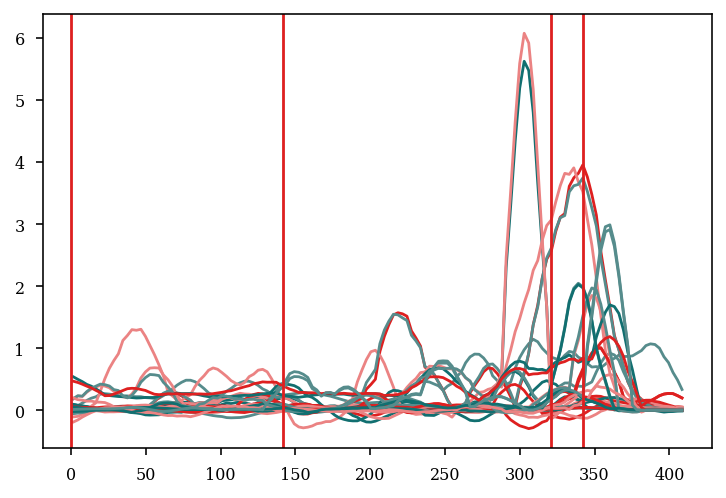

In [258]:
basepath = 'Z:\Data\AYAold\AYA10\day12'
label_df_current = label_df.query("basepath==@basepath")

tc[0].iloc[:,label_df_current.reward_assembly.values == True].plot()
plt.gca().get_legend().remove()

plt.axvline(label_df_current.x_start.iloc[0])
plt.axvline(label_df_current.x_decision.iloc[0])
plt.axvline(label_df_current.x_reward_left.iloc[0])
plt.axvline(label_df_current.x_reward_right.iloc[0])

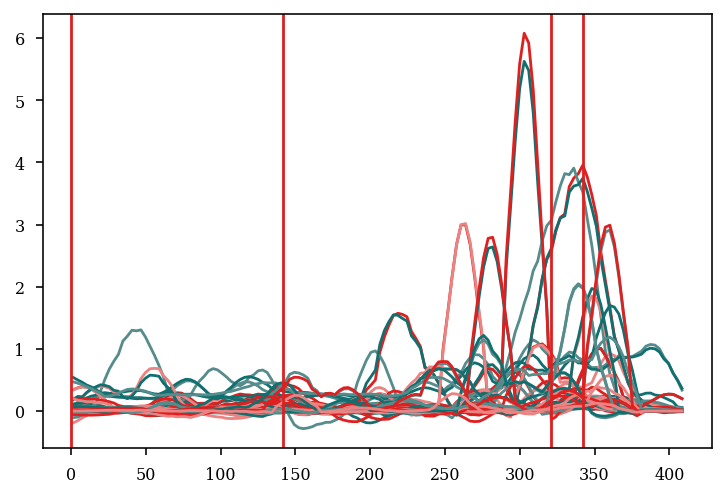

In [259]:
basepath = 'Z:\Data\AYAold\AYA10\day12'
label_df_current = label_df.query("basepath==@basepath")

tc[0].iloc[:,label_df_current.reward_encode.values == True].plot()
plt.gca().get_legend().remove()

plt.axvline(label_df_current.x_start.iloc[0])
plt.axvline(label_df_current.x_decision.iloc[0])
plt.axvline(label_df_current.x_reward_left.iloc[0])
plt.axvline(label_df_current.x_reward_right.iloc[0])

## using model where if the peak is within range

In [260]:
reward_prop_df = label_df.groupby("cross_region_label").apply(
    lambda x: pd.Series(
        {
            "n_reward_assembly": x.reward_assembly.sum(),
            "n_assembly": len(x),
            "prop_reward_assembly": x.reward_assembly.sum() / len(x),
        }
    )
).reset_index()
reward_prop_df["constant"] = 1
reward_prop_df

,cross_region_label,n_reward_assembly,n_assembly,prop_reward_assembly,constant
0,deep_mec,17.0,68.0,0.250000,1
1,deep_pfc,66.0,168.0,0.392857,1
2,sup_mec,17.0,52.0,0.326923,1
3,sup_pfc,55.0,156.0,0.352564,1


Text(0.5, 0, '')

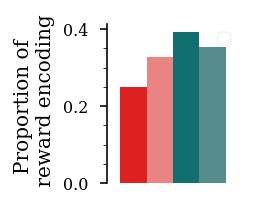

In [261]:
group_colors = {
    "deep_mec": "#de2020",
    "sup_mec": "#eb8383",
    "deep_pfc": "#116f70",
    "sup_pfc": "#568c8c",
}

sns.set_palette(sns.color_palette(group_colors.values()))

fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=0.2, subplots=(2, 1)), edgecolor=None
)
sns.barplot(data=reward_prop_df,x="constant",y="prop_reward_assembly",hue="cross_region_label",hue_order=group_colors.keys(),saturation=1)

sns.despine(bottom=True)
plt.legend("")
plt.ylabel("Proportion of \n reward encoding")
plt.gca().yaxis.set_minor_locator(AutoMinorLocator())
plt.gca().set_xticklabels([])
plt.gca().set_xticks([])
plt.gca().set_xlabel("")

# plt.savefig(
#     os.path.join(fig_save_path, "cross_region_assembly_ratemap_reward_rep_tmaze.svg"),
#     dpi=300,
#     bbox_inches="tight",
# )

## using linear model to classify

In [262]:
reward_prop_df_v2 = label_df.groupby("cross_region_label").apply(
    lambda x: pd.Series(
        {
            "n_reward_assembly": x.reward_encode.sum(),
            "n_assembly": len(x),
            "prop_reward_assembly": x.reward_encode.sum() / len(x),
        }
    )
).reset_index()
reward_prop_df_v2["constant"] = 1
reward_prop_df_v2

,cross_region_label,n_reward_assembly,n_assembly,prop_reward_assembly,constant
0,deep_mec,27.0,68.0,0.397059,1
1,deep_pfc,82.0,168.0,0.488095,1
2,sup_mec,28.0,52.0,0.538462,1
3,sup_pfc,64.0,156.0,0.410256,1


Text(0.5, 0, '')

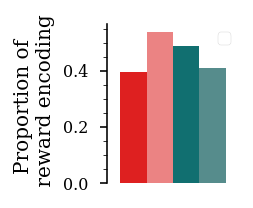

In [263]:
fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=0.2, subplots=(2, 1)), edgecolor=None
)
sns.barplot(
    data=reward_prop_df_v2,
    x="constant",
    y="prop_reward_assembly",
    hue="cross_region_label",
    hue_order=group_colors.keys(),
    saturation=1,
)

sns.despine(bottom=True)
plt.legend("")
plt.ylabel("Proportion of \n reward encoding")
plt.gca().yaxis.set_minor_locator(AutoMinorLocator())
plt.gca().set_xticklabels([])
plt.gca().set_xticks([])
plt.gca().set_xlabel("")


### collapse across cortex


In [264]:
reward_prop_df.loc[reward_prop_df.cross_region_label.str.contains("mec"),"cortex"] = "mec"
reward_prop_df.loc[reward_prop_df.cross_region_label.str.contains("pfc"),"cortex"] = "pfc"
reward_prop_df

,cross_region_label,n_reward_assembly,n_assembly,prop_reward_assembly,constant,cortex
0,deep_mec,17.0,68.0,0.250000,1,mec
1,deep_pfc,66.0,168.0,0.392857,1,pfc
2,sup_mec,17.0,52.0,0.326923,1,mec
3,sup_pfc,55.0,156.0,0.352564,1,pfc


In [265]:
count = [
    reward_prop_df.query("cortex == 'mec'").n_reward_assembly.sum(),
    reward_prop_df.query("cortex == 'pfc'").n_reward_assembly.sum(),
]
nobs = [
    reward_prop_df.query("cortex == 'mec'").n_assembly.sum(),
    reward_prop_df.query("cortex == 'pfc'").n_assembly.sum(),
]
stat, pval = proportions_ztest(count, nobs)
stat, pval

(-1.7692030686045743, 0.07685999229776905)

### ca1-mec vs ca1-pfc

In [206]:
#     labels	n_reward_assembly	n_assembly	prop_reward_assembly	constant    
# 0	deep_mec	37.0	56.0	0.660714	1
# 1	deep_pfc	25.0	36.0	0.694444	1
# 2	sup_mec	    21.0	42.0	0.500000	1
# 3	sup_pfc	    18.0	34.0	0.529412	1

In [205]:
# stat, pval = proportions_ztest([48.0+34.0+37.0+21.0, 143.0+140.0+25.0+18.0] , [126.0+80.0+56.0+42.0, 290.0+288.0+36.0+34.0])
# stat, pval


(-1.2247130798892187, 0.22068334417895852)

In [379]:
stat, pval = proportions_ztest([48.0+34.0,143.0+140.0] , [126.0+80.0,290.0+288.0])
stat, pval

(-2.2621074806288646, 0.023690763537826023)

### deep-mec vs sup-mec

In [266]:
count = reward_prop_df.query("cross_region_label=='deep_mec' | cross_region_label=='sup_mec'").n_reward_assembly
nobs = reward_prop_df.query("cross_region_label=='deep_mec' | cross_region_label=='sup_mec'").n_assembly

stat, pval = proportions_ztest(count, nobs)
stat, pval

(-0.9266478335988364, 0.3541094107998596)

### deep-pfc vs. sup-pfc

In [267]:
count = reward_prop_df.query("cross_region_label=='deep_pfc' | cross_region_label=='sup_pfc'").n_reward_assembly
nobs = reward_prop_df.query("cross_region_label=='deep_pfc' | cross_region_label=='sup_pfc'").n_assembly

stat, pval = proportions_ztest(count, nobs)
stat, pval

(0.7491672418929214, 0.45375641063025585)

In [345]:
df_peak.to_csv(r"Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_pos_maps_tmaze_df_peak.csv")


## splitter assemblies

* locate peak value in central arm
* could find assembly with peak in central,
* could find assembly with 50% difference left right.

In [268]:
for basepath_i, basepath in enumerate(label_df.basepath.unique()):

    label_df_current = label_df.query("basepath==@basepath")
    central_arm_idx = tc[basepath_i].index < label_df_current.x_decision.iloc[0]

    right_idx = (label_df_current.direction_label == "right_epochs").values
    peak_vals = tc[basepath_i].iloc[central_arm_idx,right_idx].max()
    peak_loc = np.argmax(tc[basepath_i].iloc[central_arm_idx,right_idx].values,axis=0)
    label_df.loc[(label_df.basepath == basepath) & (label_df.direction_label == "right_epochs"),"central_arm_peak_value"] = peak_vals.values
    label_df.loc[(label_df.basepath == basepath) & (label_df.direction_label == "right_epochs"),"central_arm_peak_loc"] = peak_loc

    left_idx = (label_df_current.direction_label == "left_epochs").values
    peak_vals = tc[basepath_i].iloc[central_arm_idx,left_idx].max()
    peak_loc = np.argmax(tc[basepath_i].iloc[central_arm_idx,left_idx].values,axis=0)
    label_df.loc[(label_df.basepath == basepath) & (label_df.direction_label == "left_epochs"),"central_arm_peak_value"] = peak_vals.values
    label_df.loc[(label_df.basepath == basepath) & (label_df.direction_label == "left_epochs"),"central_arm_peak_loc"] = peak_loc

    right_tc = tc[basepath_i].iloc[central_arm_idx,right_idx].values
    left_tc = tc[basepath_i].iloc[central_arm_idx,left_idx].values
    corrs = []
    for i in range(right_tc.shape[1]):
        corrs.append(np.corrcoef(right_tc[:,i],left_tc[:,i])[0,1])
    label_df.loc[(label_df.basepath == basepath) & (label_df.direction_label == "right_epochs"),"spatial_corr"] = np.array(corrs)
label_df["constant"] = 1
label_df

,assembly_n,direction_label,cross_region_label,x_start,x_decision,x_reward_left,x_reward_right,basepath,animal_id,reward_r2,reward_pval,reward_shuffle_std,reward_relation_slope,reward_encode,peak_loc,reward_assembly,central_arm_peak_value,central_arm_peak_loc,spatial_corr,constant
0,0,right_epochs,deep_mec,0.0,141.857161,342.426620,320.742053,Z:\Data\AYAold\AYA10\day12,AYA10,0.137863,0.002494,12.970596,0.000605,False,91.948529,False,0.589375,30.0,0.070678,1
1,1,right_epochs,deep_mec,0.0,141.857161,342.426620,320.742053,Z:\Data\AYAold\AYA10\day12,AYA10,0.069197,0.004988,5.802285,0.000215,False,354.227941,True,0.079805,41.0,0.601064,1
2,2,right_epochs,deep_mec,0.0,141.857161,342.426620,320.742053,Z:\Data\AYAold\AYA10\day12,AYA10,0.100909,0.002494,8.346535,-0.001944,True,263.786765,False,0.389491,2.0,-0.303316,1
3,3,right_epochs,deep_mec,0.0,141.857161,342.426620,320.742053,Z:\Data\AYAold\AYA10\day12,AYA10,0.034396,0.032419,2.522057,-0.000104,True,357.242647,True,0.070123,46.0,0.823711,1
4,4,right_epochs,deep_mec,0.0,141.857161,342.426620,320.742053,Z:\Data\AYAold\AYA10\day12,AYA10,0.106944,0.002494,11.028362,-0.003654,True,302.977941,True,0.231672,45.0,0.803688,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
439,0,left_epochs,deep_mec,0.0,87.984048,257.212112,257.810041,Z:\Data\Kenji\ec014.427_456,ec014,0.017600,0.211970,0.438577,0.000145,False,133.500000,False,0.063674,25.0,NaN,1
440,0,right_epochs,deep_mec,0.0,95.295897,263.816426,252.098965,Z:\Data\Kenji\ec016.479_487,ec016,0.004492,0.518703,-0.411634,0.000024,False,19.500000,False,0.087333,6.0,0.675927,1
441,1,right_epochs,sup_mec,0.0,95.295897,263.816426,252.098965,Z:\Data\Kenji\ec016.479_487,ec016,0.005679,0.446384,-0.339853,0.000180,False,187.500000,False,0.194847,31.0,-0.522587,1
442,0,left_epochs,deep_mec,0.0,95.295897,263.816426,252.098965,Z:\Data\Kenji\ec016.479_487,ec016,0.037176,0.062344,1.985773,0.000088,False,175.500000,False,0.077980,8.0,NaN,1


## spatial correlation

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1_deep_pfc vs. 1_sup_pfc: t-test independent samples, P_val:5.349e-01 t=-6.219e-01
1_deep_mec vs. 1_sup_mec: t-test independent samples, P_val:4.107e-01 t=8.287e-01
1_sup_mec vs. 1_sup_pfc: t-test independent samples, P_val:7.280e-01 t=3.487e-01
1_deep_mec vs. 1_deep_pfc: t-test independent samples, P_val:5.150e-02 t=1.968e+00


(<AxesSubplot:ylabel='center arm spatial corr (r)'>,
  <statannotations.Annotation.Annotation at 0x1f8131cbf70>])

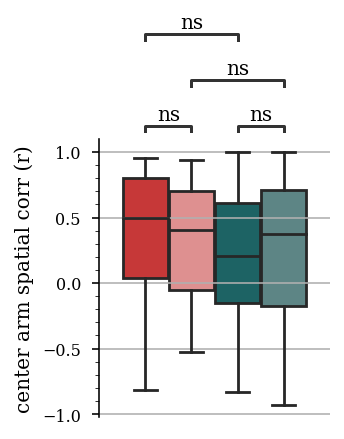

In [269]:
group_colors = {
    "deep_mec": "#de2020",
    "sup_mec": "#eb8383",
    "deep_pfc": "#116f70",
    "sup_pfc": "#568c8c",
}
sns.set_palette(sns.color_palette(group_colors.values()))

fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=0.35, subplots=(2, 1)), edgecolor=None
)
sns.boxplot(data=label_df,hue="cross_region_label",x="constant",y="spatial_corr",showfliers=False)
# sns.stripplot(data=label_df,hue="cross_region_label",x="constant",y="spatial_corr",dodge=True,color="k",s=2)
# plt.yscale("log")
# plt.axhline(1,color="k",linestyle="--",zorder=-100)
sns.despine(bottom=True)
# plt.legend("")
plt.gca().legend().set_visible(False)

plt.ylabel("center arm spatial corr (r)")
plt.gca().yaxis.set_minor_locator(AutoMinorLocator())
plt.gca().set_xticklabels([])
plt.gca().set_xticks([])
plt.gca().set_xlabel("")
plt.grid()

box_pairs = [
    ((1, "deep_mec"), (1, "sup_mec")),
    ((1, "deep_pfc"), (1, "sup_pfc")),
    ((1, "deep_pfc"), (1, "deep_mec")),
    ((1, "sup_pfc"), (1, "sup_mec")),
]
annotator = Annotator(
    plt.gca(),
    box_pairs,
    data=label_df,
    x="constant",
    y="spatial_corr",
    hue="cross_region_label",
    hue_order=group_colors.keys(),
)
annotator.configure(
    test="t-test_ind",
    text_format="star",
    loc="outside",
    comparisons_correction=None,
    verbose=1,
)
annotator.apply_and_annotate()

## pivot table to look at left and right assembly response

In [270]:
label_df_pivot = label_df.pivot(index=["basepath","assembly_n","cross_region_label"],columns="direction_label", values="central_arm_peak_value").reset_index()
# label_df_pivot["left_right_ratio"] = label_df_pivot.left_epochs / label_df_pivot.right_epochs
label_df_pivot["constant"] = 1

label_df_pivot

direction_label,basepath,assembly_n,cross_region_label,left_epochs,right_epochs,constant
0,Z:\Data\AYAold\AYA10\day12,0,deep_mec,0.660356,0.589375,1
1,Z:\Data\AYAold\AYA10\day12,1,deep_mec,0.120249,0.079805,1
2,Z:\Data\AYAold\AYA10\day12,2,deep_mec,0.408340,0.389491,1
3,Z:\Data\AYAold\AYA10\day12,3,deep_mec,0.155451,0.070123,1
4,Z:\Data\AYAold\AYA10\day12,4,deep_mec,0.331985,0.231672,1
...,...,...,...,...,...,...
217,Z:\Data\Kenji\ec014.192_204,4,sup_mec,0.212568,0.237256,1
218,Z:\Data\Kenji\ec014.398_425,0,deep_mec,0.168472,0.422294,1
219,Z:\Data\Kenji\ec014.427_456,0,deep_mec,0.063674,0.051204,1
220,Z:\Data\Kenji\ec016.479_487,0,deep_mec,0.077980,0.087333,1


In [271]:
max_min_ratio = []
for temp_df in label_df_pivot.itertuples():

    other_dir = min([temp_df.left_epochs, temp_df.right_epochs])
    preferred_dir = max([temp_df.left_epochs, temp_df.right_epochs])

    max_min_ratio.append(
        ((preferred_dir - other_dir) / (preferred_dir + other_dir)) * 100
    )

    # max_min_ratio.append(max([temp_df.left_epochs,temp_df.right_epochs]) / min([temp_df.left_epochs,temp_df.right_epochs]))
label_df_pivot["max_min_ratio"] = np.array(max_min_ratio)

label_df_pivot


direction_label,basepath,assembly_n,cross_region_label,left_epochs,right_epochs,constant,max_min_ratio
0,Z:\Data\AYAold\AYA10\day12,0,deep_mec,0.660356,0.589375,1,5.679640
1,Z:\Data\AYAold\AYA10\day12,1,deep_mec,0.120249,0.079805,1,20.216474
2,Z:\Data\AYAold\AYA10\day12,2,deep_mec,0.408340,0.389491,1,2.362563
3,Z:\Data\AYAold\AYA10\day12,3,deep_mec,0.155451,0.070123,1,37.826995
4,Z:\Data\AYAold\AYA10\day12,4,deep_mec,0.331985,0.231672,1,17.796730
...,...,...,...,...,...,...,...
217,Z:\Data\Kenji\ec014.192_204,4,sup_mec,0.212568,0.237256,1,5.488517
218,Z:\Data\Kenji\ec014.398_425,0,deep_mec,0.168472,0.422294,1,42.964789
219,Z:\Data\Kenji\ec014.427_456,0,deep_mec,0.063674,0.051204,1,10.855172
220,Z:\Data\Kenji\ec016.479_487,0,deep_mec,0.077980,0.087333,1,5.657879


<AxesSubplot:>

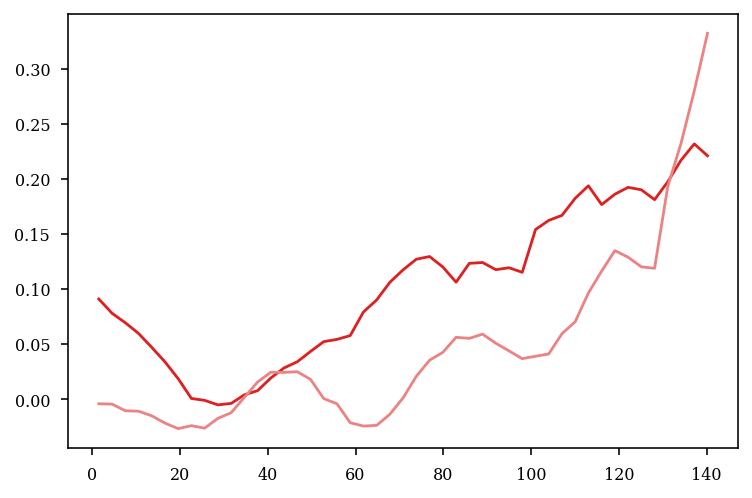

In [272]:
basepath = "Z:\Data\AYAold\AYA10\day12"
basepath_i = np.where(label_df.basepath.unique() == basepath)[0][0]
tc[basepath_i]

label_df_current = label_df.query("basepath==@basepath")
central_arm_idx = tc[basepath_i].index < label_df_current.x_decision.iloc[0]
right_idx = (label_df_current.direction_label == "right_epochs").values

tc[basepath_i].iloc[central_arm_idx,right_idx].iloc[:,4].plot()

central_arm_idx = tc[basepath_i].index < label_df_current.x_decision.iloc[0]
left_idx = (label_df_current.direction_label == "left_epochs").values

tc[basepath_i].iloc[central_arm_idx,left_idx].iloc[:,4].plot()

c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:k'` for same effect.


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1_deep_pfc vs. 1_sup_pfc: t-test independent samples, P_val:8.069e-01 t=-2.449e-01
1_deep_mec vs. 1_sup_mec: t-test independent samples, P_val:4.127e-01 t=-8.250e-01
1_sup_mec vs. 1_sup_pfc: t-test independent samples, P_val:7.058e-01 t=-3.785e-01
1_deep_mec vs. 1_deep_pfc: t-test independent samples, P_val:1.436e-01 t=-1.473e+00


(<AxesSubplot:ylabel='assembly strength difference (%)'>,
  <statannotations.Annotation.Annotation at 0x1f7c352c610>])

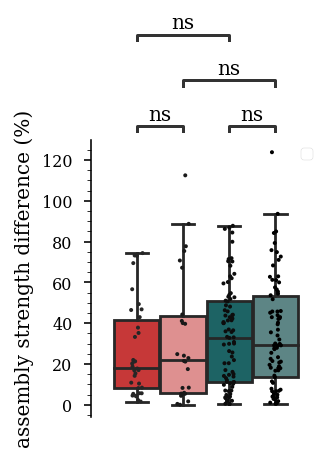

In [273]:
group_colors = {
    "deep_mec": "#de2020",
    "sup_mec": "#eb8383",
    "deep_pfc": "#116f70",
    "sup_pfc": "#568c8c",
}
sns.set_palette(sns.color_palette(group_colors.values()))

fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=0.35, subplots=(2, 1)), edgecolor=None
)
sns.boxplot(data=label_df_pivot,hue="cross_region_label",x="constant",y="max_min_ratio",showfliers=False)
sns.stripplot(data=label_df_pivot,hue="cross_region_label",x="constant",y="max_min_ratio",dodge=True,color="k",s=2)
# plt.yscale("log")
# plt.axhline(1,color="k",linestyle="--",zorder=-100)
sns.despine(bottom=True)
plt.legend("")
plt.ylabel("assembly strength difference (%)")
plt.gca().yaxis.set_minor_locator(AutoMinorLocator())
plt.gca().set_xticklabels([])
plt.gca().set_xticks([])
plt.gca().set_xlabel("")

box_pairs = [
    ((1, "deep_mec"), (1, "sup_mec")),
    ((1, "deep_pfc"), (1, "sup_pfc")),
    ((1, "deep_pfc"), (1, "deep_mec")),
    ((1, "sup_pfc"), (1, "sup_mec")),
]
annotator = Annotator(
    plt.gca(),
    box_pairs,
    data=label_df_pivot,
    x="constant",
    y="max_min_ratio",
    hue="cross_region_label",
    hue_order=group_colors.keys(),
)
annotator.configure(
    test="t-test_ind",
    text_format="star",
    loc="outside",
    comparisons_correction=None,
    verbose=1,
)
annotator.apply_and_annotate()

In [286]:
splitter_prop_df = label_df_pivot.groupby("cross_region_label").apply(
    lambda x: pd.Series(
        {
            "n_splitter_assembly": (x.max_min_ratio > 50).sum(),
            "n_assembly": len(x),
        }
    )
).reset_index()
splitter_prop_df["splitter_prop"] = splitter_prop_df.n_splitter_assembly / splitter_prop_df.n_assembly
splitter_prop_df["constant"] = 1
splitter_prop_df

,cross_region_label,n_splitter_assembly,n_assembly,splitter_prop,constant
0,deep_mec,5,34,0.147059,1
1,deep_pfc,22,84,0.261905,1
2,sup_mec,6,26,0.230769,1
3,sup_pfc,21,78,0.269231,1


Text(0.5, 0, '')

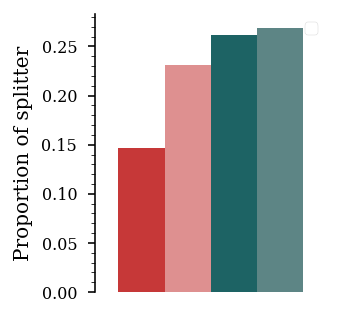

In [275]:
group_colors = {
    "deep_mec": "#de2020",
    "sup_mec": "#eb8383",
    "deep_pfc": "#116f70",
    "sup_pfc": "#568c8c",
}
fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=0.35, subplots=(2, 1)), edgecolor=None
)
sns.barplot(data=splitter_prop_df,x="constant",y="splitter_prop",hue="cross_region_label",hue_order=group_colors.keys())

sns.despine(bottom=True)
plt.legend("")
plt.ylabel("Proportion of splitter")
plt.gca().yaxis.set_minor_locator(AutoMinorLocator())
plt.gca().set_xticklabels([])
plt.gca().set_xticks([])
plt.gca().set_xlabel("")

## Decision encoding

In [276]:
decision_assembly = []
for basepath_i, basepath in enumerate(label_df.basepath.unique()):

    label_df_current = label_df.query("basepath==@basepath")

    peak_locs = tc[basepath_i].index[np.argmax(tc[basepath_i].values, axis=0)]

    right_peaks = peak_locs[(label_df_current.direction_label == "right_epochs").values]
    left_peaks = peak_locs[(label_df_current.direction_label == "left_epochs").values]

    label_df.loc[(label_df.basepath == basepath) & (label_df.direction_label == "right_epochs"),"peak_loc"] = right_peaks
    label_df.loc[(label_df.basepath == basepath) & (label_df.direction_label == "left_epochs"),"peak_loc"] = left_peaks

    x_decision_right = label_df_current.x_decision.iloc[0]
    decision_assembly = (right_peaks > x_decision_right - 25) & (right_peaks < x_decision_right + 25)
    label_df.loc[(label_df.basepath == basepath) & (label_df.direction_label == "right_epochs"),"decision_assembly"] = decision_assembly
    
    x_decision_left = label_df_current.x_decision.iloc[0]
    decision_assembly = (left_peaks > x_decision_left - 25) & (left_peaks < x_decision_left + 25)
    label_df.loc[(label_df.basepath == basepath) & (label_df.direction_label == "left_epochs"),"decision_assembly"] = decision_assembly
label_df

,assembly_n,direction_label,cross_region_label,x_start,x_decision,x_reward_left,x_reward_right,basepath,animal_id,reward_r2,...,reward_shuffle_std,reward_relation_slope,reward_encode,peak_loc,reward_assembly,central_arm_peak_value,central_arm_peak_loc,spatial_corr,constant,decision_assembly
0,0,right_epochs,deep_mec,0.0,141.857161,342.426620,320.742053,Z:\Data\AYAold\AYA10\day12,AYA10,0.137863,...,12.970596,0.000605,False,91.948529,False,0.589375,30.0,0.070678,1,False
1,1,right_epochs,deep_mec,0.0,141.857161,342.426620,320.742053,Z:\Data\AYAold\AYA10\day12,AYA10,0.069197,...,5.802285,0.000215,False,354.227941,True,0.079805,41.0,0.601064,1,False
2,2,right_epochs,deep_mec,0.0,141.857161,342.426620,320.742053,Z:\Data\AYAold\AYA10\day12,AYA10,0.100909,...,8.346535,-0.001944,True,263.786765,False,0.389491,2.0,-0.303316,1,False
3,3,right_epochs,deep_mec,0.0,141.857161,342.426620,320.742053,Z:\Data\AYAold\AYA10\day12,AYA10,0.034396,...,2.522057,-0.000104,True,357.242647,True,0.070123,46.0,0.823711,1,False
4,4,right_epochs,deep_mec,0.0,141.857161,342.426620,320.742053,Z:\Data\AYAold\AYA10\day12,AYA10,0.106944,...,11.028362,-0.003654,True,302.977941,True,0.231672,45.0,0.803688,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
439,0,left_epochs,deep_mec,0.0,87.984048,257.212112,257.810041,Z:\Data\Kenji\ec014.427_456,ec014,0.017600,...,0.438577,0.000145,False,133.500000,False,0.063674,25.0,NaN,1,False
440,0,right_epochs,deep_mec,0.0,95.295897,263.816426,252.098965,Z:\Data\Kenji\ec016.479_487,ec016,0.004492,...,-0.411634,0.000024,False,19.500000,False,0.087333,6.0,0.675927,1,False
441,1,right_epochs,sup_mec,0.0,95.295897,263.816426,252.098965,Z:\Data\Kenji\ec016.479_487,ec016,0.005679,...,-0.339853,0.000180,False,187.500000,False,0.194847,31.0,-0.522587,1,False
442,0,left_epochs,deep_mec,0.0,95.295897,263.816426,252.098965,Z:\Data\Kenji\ec016.479_487,ec016,0.037176,...,1.985773,0.000088,False,175.500000,False,0.077980,8.0,NaN,1,False


In [277]:
decision_prop_df = label_df.groupby("cross_region_label").apply(
    lambda x: pd.Series(
        {
            "n_decision_assembly": x.decision_assembly.sum(),
            "n_assembly": len(x),
            "prop_decision_assembly": x.decision_assembly.sum() / len(x),
        }
    )
).reset_index()
decision_prop_df["constant"] = 1
decision_prop_df

,cross_region_label,n_decision_assembly,n_assembly,prop_decision_assembly,constant
0,deep_mec,5.0,68.0,0.073529,1
1,deep_pfc,26.0,168.0,0.154762,1
2,sup_mec,6.0,52.0,0.115385,1
3,sup_pfc,19.0,156.0,0.121795,1


In [278]:
decision_prop_df.n_decision_assembly.sum()

56.0

Text(0.5, 0, '')

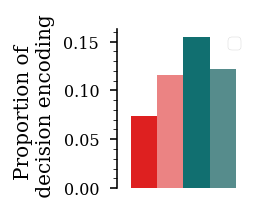

In [279]:
group_colors = {
    "deep_mec": "#de2020",
    "sup_mec": "#eb8383",
    "deep_pfc": "#116f70",
    "sup_pfc": "#568c8c",
}
fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=0.2, subplots=(2, 1)), edgecolor=None
)
sns.barplot(data=decision_prop_df,x="constant",y="prop_decision_assembly",hue="cross_region_label",hue_order=group_colors.keys(),saturation=1)

sns.despine(bottom=True)
plt.legend("")
plt.ylabel("Proportion of \n decision encoding")
plt.gca().yaxis.set_minor_locator(AutoMinorLocator())
plt.gca().set_xticklabels([])
plt.gca().set_xticks([])
plt.gca().set_xlabel("")

# plt.savefig(
#     os.path.join(fig_save_path, "cross_region_assembly_ratemap_decision_rep_tmaze.svg"),
#     dpi=300,
#     bbox_inches="tight",
# )

In [284]:
count = decision_prop_df.query("cross_region_label=='deep_mec' | cross_region_label=='sup_mec'").n_decision_assembly
nobs = decision_prop_df.query("cross_region_label=='deep_mec' | cross_region_label=='sup_mec'").n_assembly

stat, pval = proportions_ztest(count, nobs, alternative="smaller")
stat, pval

(-0.7873840602208698, 0.2155285374356991)

In [285]:
count

0    5.0
2    6.0
Name: n_decision_assembly, dtype: float64

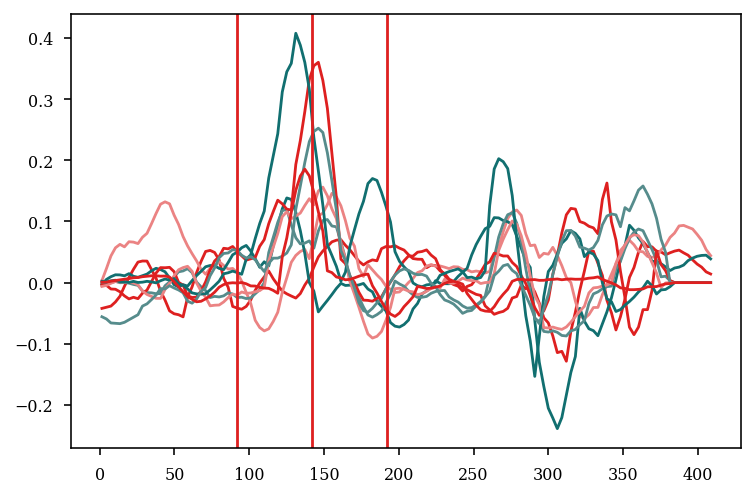

In [281]:
basepath = 'Z:\Data\AYAold\AYA10\day12'
label_df_current = label_df.query("basepath==@basepath")

tc[0].iloc[:,label_df_current.decision_assembly.values == True].plot()
plt.gca().get_legend().remove()

# plt.axvline(label_df_current.x_start.iloc[0])
plt.axvline(label_df_current.x_decision.iloc[0]-50)
plt.axvline(label_df_current.x_decision.iloc[0])
plt.axvline(label_df_current.x_decision.iloc[0]+50)

# plt.axvline(label_df_current.x_reward_left.iloc[0])
# plt.axvline(label_df_current.x_reward_right.iloc[0])

## Testing below

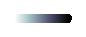

In [25]:
a = np.array([[0,1]])
plt.figure(figsize=(.5, .1))
img = plt.imshow(a, cmap="bone_r")
plt.gca().set_visible(False)
cax = plt.axes([0.1, 0.2, 0.8, 0.6])
plt.colorbar(orientation="horizontal", cax=cax,extend='max')
plt.axis("off")
plt.savefig(
    os.path.join(fig_save_path, "bone_r_colorbar.svg"),
    dpi=300,
    bbox_inches="tight",
)

In [191]:
def locate_t_maze_key_locations(current_pos):
    start_pos = (
        current_pos.dropna(subset=["linearized", "x", "y"])
        .query("states==0")
        .sort_values(by="linearized")[["x", "y"]][:10]
        .mean()
        .values
    )
    decision_pos = (
        current_pos.dropna(subset=["linearized", "x", "y"])
        .query("states==0")
        .sort_values(by="linearized", ascending=False)[["x", "y"]][:10]
        .mean()
        .values
    )
    reward_right_pos = start_pos.copy()
    reward_left_pos = start_pos.copy()
    return start_pos, decision_pos, reward_left_pos, reward_right_pos


env = "Mwheel|Tmaze|tmaze"
for basepath in session_df.basepath.unique():

    # if "FujisawaS" in basepath:
    #     continue

    epoch_df = loading.load_epoch(basepath)
    task_idx = assembly_multi_region_pos_maps_tmaze_ind_detect.locate_task_epoch(
        epoch_df, env
    )

    position_df = loading.load_animal_behavior(basepath)

    current_pos = position_df.query(
        "time >= @epoch_df.iloc[@task_idx].startTime & time <= @epoch_df.iloc[@task_idx].stopTime"
    )
    if current_pos.dropna(subset=["x", "y"]).shape[0] == 0:
        continue
    try:
        start_pos, decision_pos, reward_left_pos, reward_right_pos = locate_t_maze_key_locations(current_pos)
    except:
        print(basepath)
    plt.figure()
    sns.scatterplot(data=current_pos,x="x",y="y",s=3,color="grey")
    plt.scatter(start_pos[0],start_pos[1],s=100,label="start_pos")
    plt.scatter(decision_pos[0],decision_pos[1],s=100,label="decision_pos")
    plt.axis("equal")
    plt.title(f"{basepath}, {epoch_df.iloc[task_idx].environment}")
    plt.legend()
    plt.show()

In [145]:
session = r"Z:\Data\FujisawaS\EE\EE0622fm\linearization_nodes_edges.pkl"
with open(session, "rb") as f:
    nodes_and_edges = pickle.load(f)

In [154]:
nodes_and_edges = results

In [155]:
nodes_and_edges["node_positions"][0]


array([121.64689906,  64.64685961])

In [146]:
results

{'node_positions': array([[121.64689906,  64.64685961],
        [ 37.32307141,  53.81760092],
        [ 38.76697257,  23.92884694],
        [121.64689906,  27.39420972],
        [ 40.06648361,  86.59415721],
        [119.62543744,  87.46049791]]),
 'edges': [[0, 1], [1, 2], [2, 3], [3, 0], [1, 4], [4, 5], [5, 0]]}

In [ ]:
sessions = glob.glob(save_path + os.sep + "*.pkl")
df = pd.DataFrame()
for session in sessions:
    if verbose:
        print(session)
    with open(session, "rb") as f:
        results = pickle.load(f)
    if results is None:
        continue

In [179]:
results = assembly_multi_region_pos_maps_tmaze.run(r"Z:\Data\FujisawaS\EE\EE0622fm")


c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars


In [182]:
results["tc"]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
1.5,0.014633,1.950871,0.082189,0.034171,0.019521,0.182541,0.005411,-0.079738,0.440265,0.085375,-0.005799,1.113188,0.006413,0.102403,0.053108,-0.034352,0.014257,-0.005367,-0.045598,0.230994
4.5,0.014032,1.635159,0.066320,0.052679,0.018279,0.398782,0.004799,-0.059724,0.576244,0.082401,-0.002773,0.900862,0.004090,0.089567,0.059000,0.013173,0.008022,-0.007985,-0.027725,0.227636
7.5,0.008426,1.331277,0.052029,0.070949,0.027939,0.733487,0.002125,-0.036142,0.755786,0.087125,-0.001188,0.707050,0.005268,0.078122,0.064555,0.031541,0.003177,-0.025209,-0.012106,0.215425
10.5,0.007291,1.042233,0.048088,0.084109,0.034754,0.956302,0.001203,-0.006373,0.886328,0.082837,0.005398,0.530260,0.035177,0.094574,0.075647,0.060710,-0.002785,-0.030242,-0.006151,0.198986
13.5,0.008358,0.775445,0.041914,0.091755,0.048153,1.406249,0.000372,0.015983,0.967750,0.080377,0.008705,0.360036,0.045970,0.096423,0.084242,0.069835,-0.007068,-0.033007,0.003712,0.167406
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226.5,0.016905,0.064006,0.565370,0.014727,0.042247,0.015219,0.005497,0.319673,0.093688,0.204337,0.019128,0.012847,-0.039480,0.011192,0.082220,0.040502,-0.002776,0.120974,-0.003789,1.162956
229.5,0.014804,0.067593,0.659671,-0.017119,0.030117,0.017308,0.002945,0.295316,0.103808,0.190509,0.016549,0.000344,-0.033267,-0.000357,0.061541,0.037601,-0.004888,0.095021,-0.009532,1.073769
232.5,0.012350,0.075965,0.747340,-0.030387,0.037309,0.018267,-0.000097,0.270771,0.113325,0.175363,0.013319,-0.008800,-0.025719,-0.003955,0.043560,0.032848,-0.006992,0.068378,-0.015535,0.908838
235.5,0.007760,0.079275,0.819485,-0.033909,0.050370,0.017206,-0.001328,0.225909,0.117828,0.151815,0.010273,-0.012795,-0.017400,-0.003464,0.028136,0.028336,-0.007267,0.041486,-0.023607,0.718293


In [188]:
(results["tc"].index > results["label_df"].x_start[0]-6) & (results["tc"].index < results["label_df"].x_start[0]+6)

array([ True,  True,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False])

<AxesSubplot:>

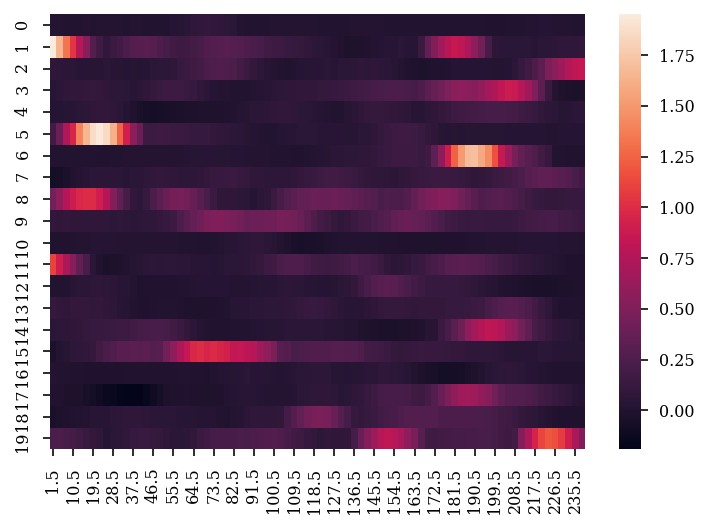

In [190]:
sns.heatmap(results["tc"].T)

In [ ]:
results["label_df"].direction_label == "right_epochs"

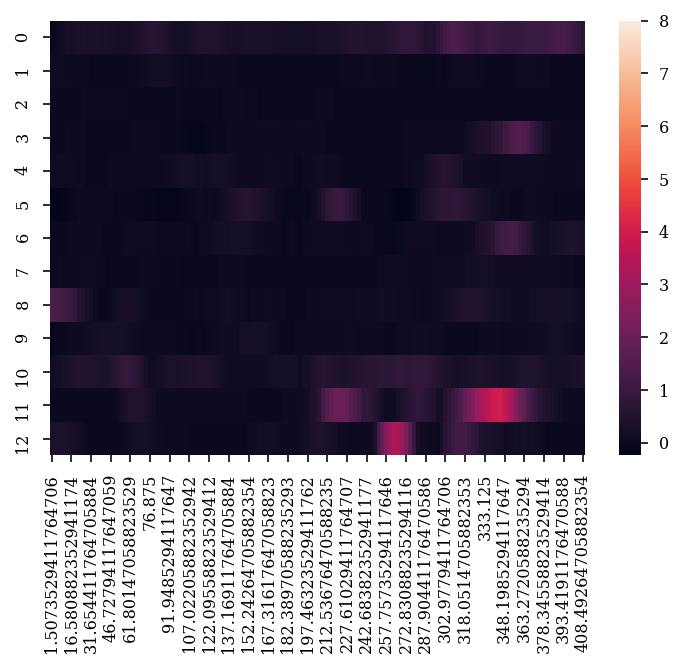

<AxesSubplot:>

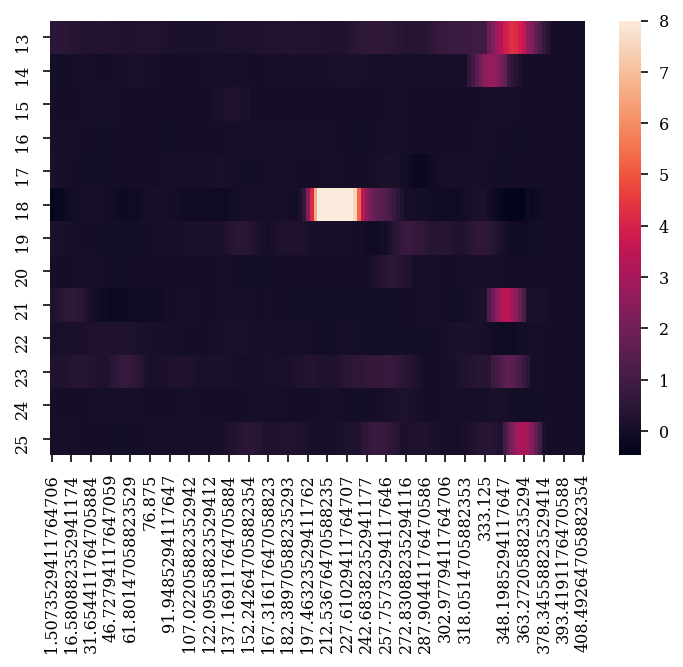

In [128]:

sns.heatmap(results["tc"].loc[:,results["label_df"].direction_label == "right_epochs"].T,vmax=8)
plt.show()
sns.heatmap(results["tc"].loc[:,results["label_df"].direction_label == "left_epochs"].T,vmax=8)


In [37]:
position_df = loading.load_animal_behavior(r"Z:\Data\AYAold\AYA10\day12")
position_df

,time,x,y,linearized,units,projected_x,projected_y,sr,timestamps,speed,acceleration,states,epochs,environment
0,0.0000,NaN,NaN,NaN,cm,NaN,NaN,39.0625,0.0000,NaN,0.0,NaN,trial_1,tmaze
1,0.0256,NaN,NaN,NaN,cm,NaN,NaN,39.0625,0.0256,NaN,NaN,NaN,trial_1,tmaze
2,0.0512,NaN,NaN,NaN,cm,NaN,NaN,39.0625,0.0512,NaN,NaN,NaN,trial_1,tmaze
3,0.0768,NaN,NaN,NaN,cm,NaN,NaN,39.0625,0.0768,NaN,NaN,NaN,trial_1,tmaze
4,0.1024,NaN,NaN,NaN,cm,NaN,NaN,39.0625,0.1024,NaN,NaN,NaN,trial_1,tmaze
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558869,14307.0464,NaN,NaN,NaN,cm,NaN,NaN,39.0625,14307.0464,0.0,0.0,NaN,trial_4,sleep
558870,14307.0720,NaN,NaN,NaN,cm,NaN,NaN,39.0625,14307.0720,0.0,0.0,NaN,trial_4,sleep
558871,14307.0976,NaN,NaN,NaN,cm,NaN,NaN,39.0625,14307.0976,0.0,0.0,NaN,NaN,NaN
558872,14307.1232,NaN,NaN,NaN,cm,NaN,NaN,39.0625,14307.1232,NaN,NaN,NaN,NaN,NaN


In [50]:
def find_good_laps(pos, dir_epoch, thres=0.5, binsize=6, min_laps=10):
    """
    find_good_laps: finds good laps in behavior data
        Made to find good laps in nelpy array for replay analysis
    input:
        pos: nelpy analog array with single dim
        dir_epoch: epoch to find good lap
        thres: occupancy threshold for good lap
        binsize: size of bins to calculate occupancy
    output:
        good_laps: epoch array of good laps
    """
    # make bin edges to calc occupancy
    x_edges = np.arange(np.nanmin(pos.data[0]), np.nanmax(pos.data[0]), binsize)
    # initialize occupancy matrix (position x time)
    occ = np.zeros([len(x_edges) - 1, dir_epoch.n_intervals])
    # iterate through laps
    for i, ep in enumerate(dir_epoch):
        # bin position per lap
        occ[:, i], _ = np.histogram(pos[ep].data[0], bins=x_edges)
    # calc percent occupancy over position bins per lap and find good laps
    good_laps = np.where(~((np.sum(occ == 0, axis=0) / occ.shape[0]) > thres))[0]
    # if no good laps, return empty epoch
    if (len(good_laps) == 0) | (len(good_laps) < min_laps):
        dir_epoch = nel.EpochArray()
    else:
        dir_epoch = dir_epoch[good_laps]
    return dir_epoch

In [56]:
np.vstack([position_df.query("epochs=='trial_1' & states==1").timestamps,position_df.query("epochs=='trial_1' & states==1").timestamps])

array([[  76.672 ,   76.6976,   76.7232, ..., 1615.7184, 1615.744 ,
        1615.7696],
       [  76.672 ,   76.6976,   76.7232, ..., 1615.7184, 1615.744 ,
        1615.7696]])

In [59]:
position_df.query("epochs=='trial_1' & states==1").timestamps

2995       76.6720
2996       76.6976
2997       76.7232
3040       77.8240
3041       77.8496
           ...    
62842    1608.7552
62843    1608.7808
63114    1615.7184
63115    1615.7440
63116    1615.7696
Name: timestamps, Length: 22745, dtype: float64

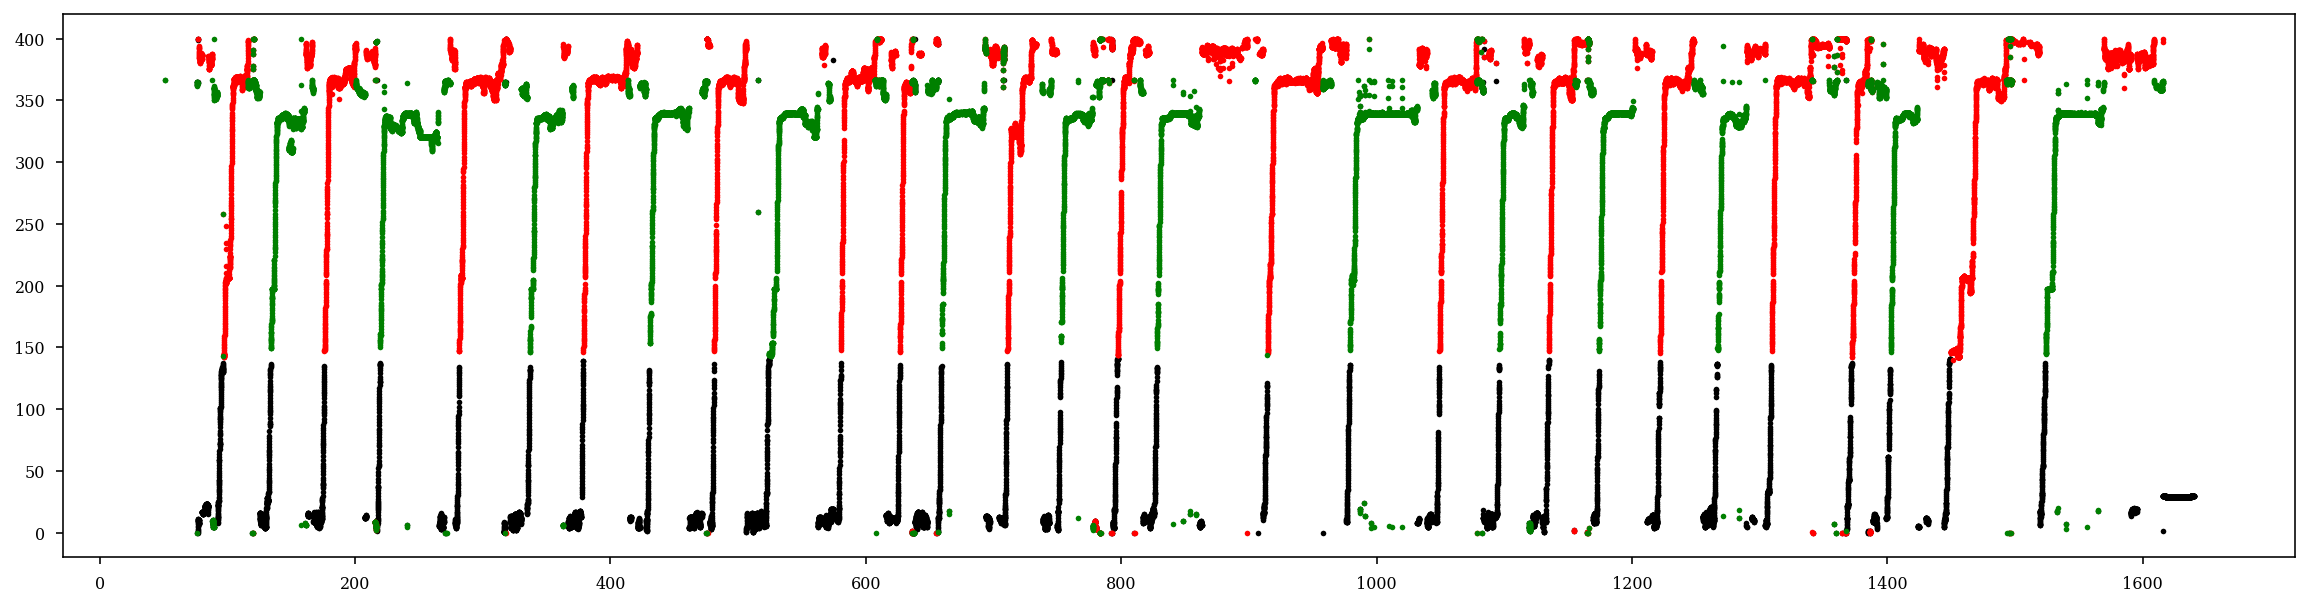

In [72]:
    
state_0_epochs = nel.EpochArray(
    np.vstack(
        [
            position_df.query("epochs=='trial_1' & states==0").timestamps,
            position_df.query("epochs=='trial_1' & states==0").timestamps,
        ]
    ).T
).merge(gap=1)

state_1_epochs = nel.EpochArray(
    np.vstack(
        [
            position_df.query("epochs=='trial_1' & states==1").timestamps,
            position_df.query("epochs=='trial_1' & states==1").timestamps,
        ]
    ).T
).merge(gap=1)

state_2_epochs = nel.EpochArray(
    np.vstack(
        [
            position_df.query("epochs=='trial_1' & states==2").timestamps,
            position_df.query("epochs=='trial_1' & states==2").timestamps,
        ]
    ).T
).merge(gap=1)

plt.figure(figsize=(20,5))

plt.plot(pos[state_0_epochs].abscissa_vals, pos[state_0_epochs].data[0],'.k')
plt.plot(pos[state_1_epochs].abscissa_vals, pos[state_1_epochs].data[0],'.r')
plt.plot(pos[state_2_epochs].abscissa_vals, pos[state_2_epochs].data[0],'.g')

plt.show()

In [101]:
def dissociate_laps_by_states(states, dir_epoch, states_of_interest=[1,2]):
    # unique_states = np.unique(states.data[~np.isnan(states.data)])
    lap_id = []
    for ep in dir_epoch:
        state_count = []
        for us in states_of_interest:
            state_count.append(np.nansum(states[ep].data == us))
        lap_id.append(states_of_interest[np.argmax(state_count)])
    return np.array(lap_id).astype(int)

In [112]:

inbound_epochs


<empty EpochArray at 0x1ddfb9df310>

(<EpochArray at 0x1ddfb9df6d0: 16 epochs> of length 7:48:454 minutes,
 <EpochArray at 0x1de10295580: 14 epochs> of length 4:58:188 minutes)

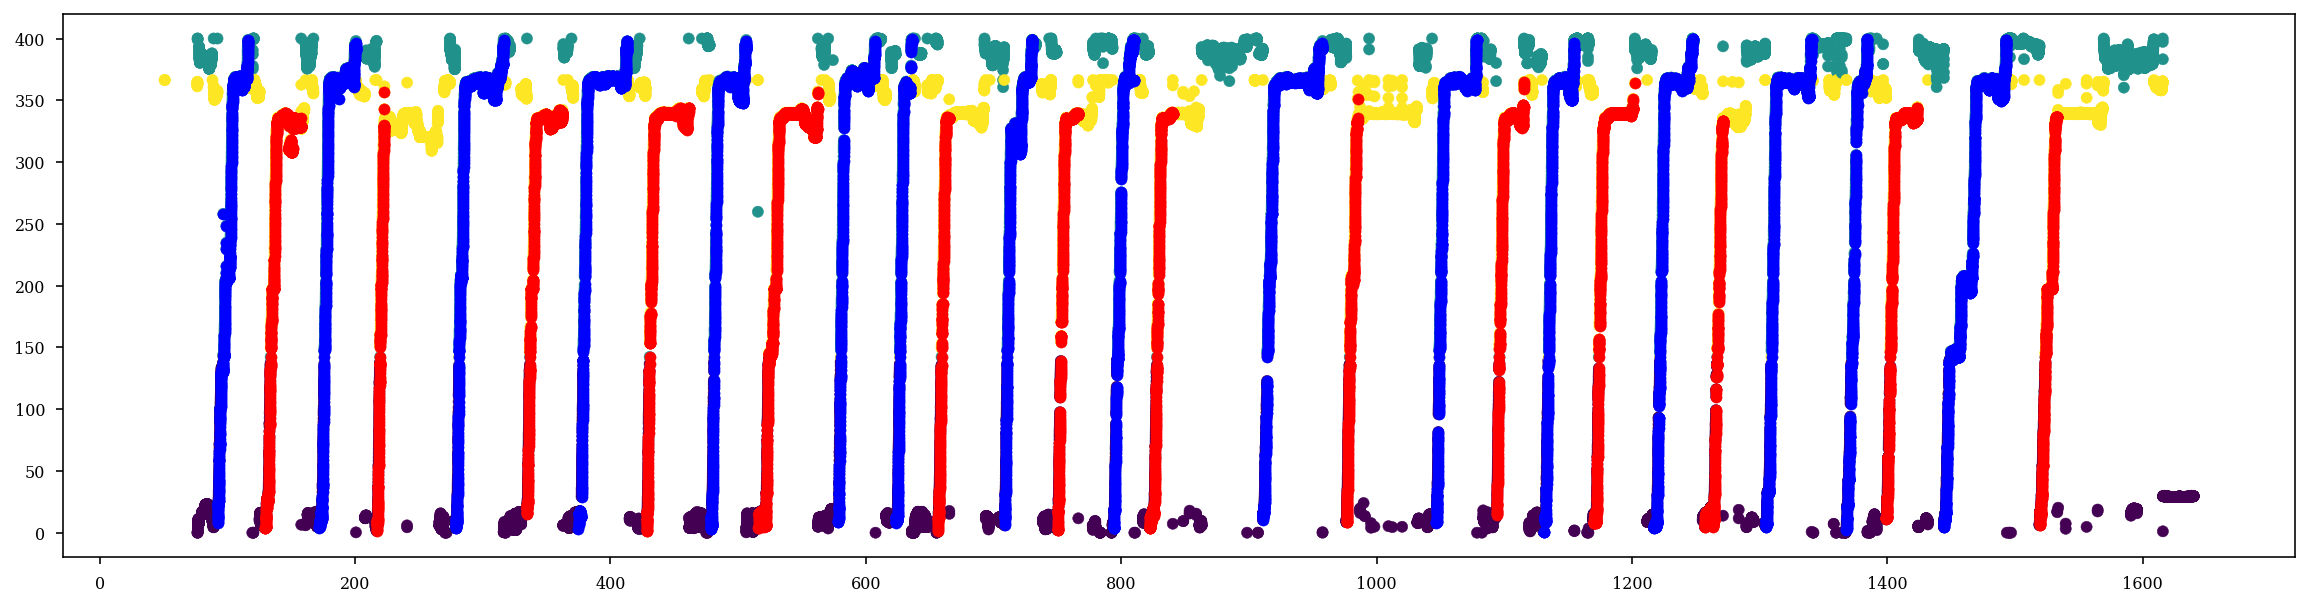

In [111]:
plt.figure(figsize=(20,5))
plt.scatter(
    position_df.query("epochs=='trial_1'").timestamps,
    position_df.query("epochs=='trial_1'").linearized,
    c=position_df.query("epochs=='trial_1'").states,
)
# plt.show()

outbound_epochs, inbound_epochs = functions.get_linear_track_lap_epochs(
    position_df.query("epochs=='trial_1'").timestamps, position_df.query("epochs=='trial_1'").linearized, newLapThreshold=20
)
pos = nel.PositionArray(
    data=position_df.query("epochs=='trial_1'")["linearized"].values.T,
    timestamps=position_df.query("epochs=='trial_1'").timestamps.values,
)
states = nel.AnalogSignalArray(data=position_df.query("epochs=='trial_1'")["states"].values.T,
    timestamps=position_df.query("epochs=='trial_1'").timestamps.values)

outbound_epochs = functions.find_good_lap_epochs(pos, outbound_epochs)
inbound_epochs = functions.find_good_lap_epochs(pos, inbound_epochs)

lap_id = dissociate_laps_by_states(states, outbound_epochs, states_of_interest=[1,2])
right_epochs = nel.EpochArray(data=outbound_epochs.data[lap_id==1,:])
left_epochs = nel.EpochArray(data=outbound_epochs.data[lap_id==2,:])

# plt.figure(figsize=(20,5))
plt.scatter(
    pos[right_epochs].abscissa_vals,
    pos[right_epochs].data[0].T,
    color="b"
)
plt.scatter(
    pos[left_epochs].abscissa_vals,
    pos[left_epochs].data[0].T,
    color="r"
)
right_epochs,left_epochs

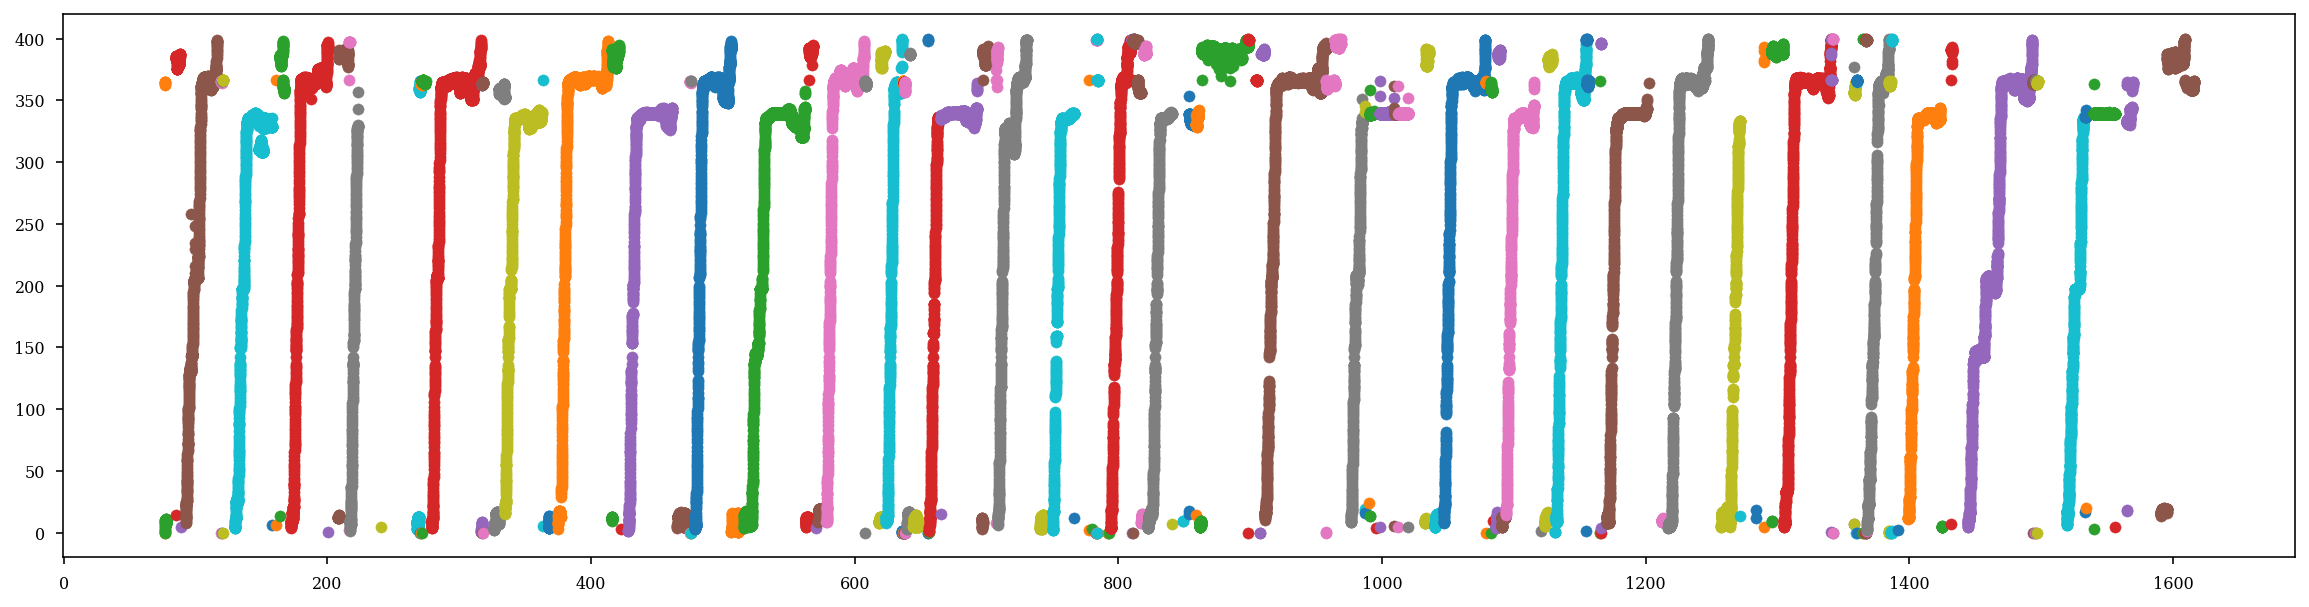

In [49]:
import logging
logging.getLogger().setLevel(logging.ERROR)
plt.figure(figsize=(20,5))

for ep in outbound_epochs:
    plt.scatter(
        pos[ep].abscissa_vals,
        pos[ep].data[0].T,
    )

In [ ]:
for basepath in epoch_df.query("environment == 'tmaze' & (mec|pfc)").basepath.unique():
    epoch_df_current = loading.load_epoch(basepath)

    startTime = epoch_df_current[epoch_df_current.environment == 'tmaze'].startTime
    stopTime = epoch_df_current[epoch_df_current.environment == 'tmaze'].stopTime

    position_df = loading.load_animal_behavior(basepath)
    try:
        position_df.timestamps 
    except:
        continue
    idx = (position_df.timestamps > startTime.iloc[0]) & (position_df.timestamps < stopTime.iloc[0])
    plt.plot(position_df[idx].x,position_df[idx].y)
    plt.axis("equal")
    plt.title(basepath)
    plt.show()    

In [ ]:
for basepath in epoch_df.query("environment.str.contains('Mwheel|Tmaze|tmaze|wmaze') & (mec|pfc)").basepath.unique():
    position_df = loading.load_animal_behavior(basepath)
    plt.plot(position_df.x,position_df.y)
    plt.axis("equal")
    plt.title(basepath)
    plt.show()    